## 데이터 준비

파이토치에서는 데이터 준비를 위해 `torch.utils.data`의 `Dataset`과 `DataLoader` 사용 가능

- `Dataset`에는 다양한 데이터셋이 존재 (MNIST, FashionMNIST, CIFAR10, ...)
  - Vision Dataset: https://pytorch.org/vision/stable/datasets.html
  - Text Dataset: https://pytorch.org/text/stable/datasets.html
  - Audio Dataset: https://pytorch.org/audio/stable/datasets.html
- `DataLoader`와 `Dataset`을 통해 `batch_size`, `train` 여부, `transform` 등을 인자로 넣어 데이터를 어떻게 load할 것인지 정해줄 수 있음

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader

토치비전(`torchvision`)은 파이토치에서 제공하는 데이터셋들이 모여있는 패키지

- `transforms`: 전처리할 때 사용하는 메소드 (https://pytorch.org/docs/stable/torchvision/transforms.html)
- `transforms`에서 제공하는 클래스 이외는 일반적으로 클래스를 따로 만들어 전처리 단계를 진행

In [2]:
import torchvision.transforms as transforms
from torchvision import datasets

`DataLoader`의 인자로 들어갈 `transform`을 미리 정의할 수 있고, `Compose`를 통해 리스트 안에 순서대로 전처리 진행

`ToTensor`()를 하는 이유는 `torchvision`이 PIL Image 형태로만 입력을 받기 때문에 데이터 처리를 위해서 Tensor형으로 변환 필요

In [3]:
mnist_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5, ), std=(1.0, ))]) # 각 채널별로 평균 0.5, 표준편차 1.0으로 정규화

In [4]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=mnist_transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=mnist_transform)

`DataLoader`는 데이터 전체를 보관했다가 실제 모델 학습을 할 때 `batch_size` 크기만큼 데이터를 가져옴

In [5]:
train_loader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True, num_workers=2)
test_loader = DataLoader(dataset=test_dataset, batch_size=8, shuffle=False, num_workers=2)

In [6]:
data_iter = iter(train_loader)        # 반복자로 변환
images, labels = next(data_iter)      # 반복자로부터 데이터를 가져옴
images.shape, labels.shape            # 형태 확인(배치 크기, 채널 수, 높이, 너비), (배치 크기)  -> 8개의 이미지, 8개의 레이블

(torch.Size([8, 1, 28, 28]), torch.Size([8]))

In [7]:
torch_image = torch.squeeze(images[0]) # squeeze() 함수를 사용하여 채널 차원을 제거
torch_image.shape

torch.Size([28, 28])

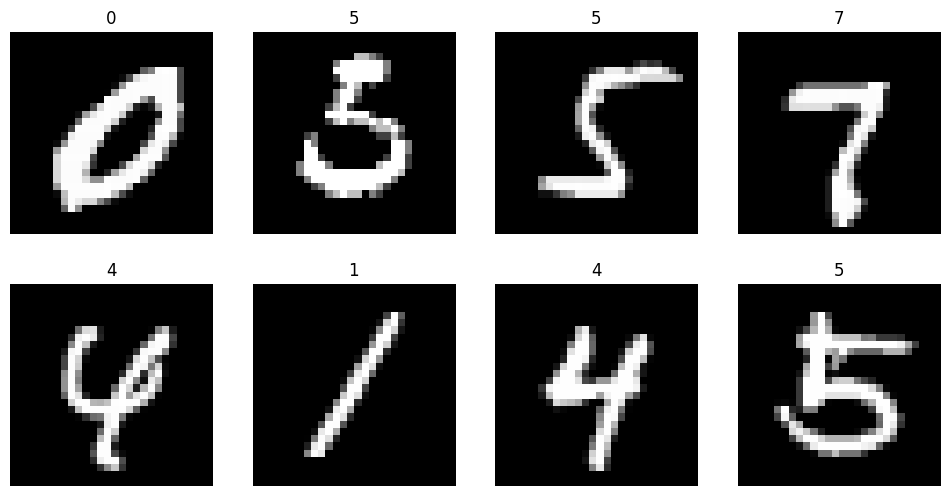

In [8]:
import matplotlib.pyplot as plt 

figure = plt.figure(figsize=(12, 6))
cols, rows = 4, 2
for i in range(1, cols * rows + 1):
  sample_idx = torch.randint(len(train_dataset), size=(1, )).item()  # 0부터 len(train_dataset) - 1까지의 정수 중 하나를 랜덤하게 선택
  img, label = train_dataset[sample_idx]  # 랜덤하게 선택한 인덱스의 이미지와 레이블을 가져옴
  figure.add_subplot(rows, cols, i)       # 그림을 그릴 위치를 지정
  plt.title(label)                        # 레이블을 제목으로 설정
  plt.axis("off")                         # 축을 제거하여 이미지만 표시
  plt.imshow(img.squeeze(), cmap="gray")  # 이미지를 그림
plt.show()

## 신경망 구성

- `레이어(layer)`: 신경망의 핵심 데이터 구조로 하나 이상의 텐서를 입력받아 하나 이상의 텐서를 출력
- `모듈(module)`: 한 개 이상의 계층이 모여서 구성
- `모델(model)`: 한 개 이상의 모듈이 모여서 구성

In [9]:
import torch

### `torch.nn` 패키지

주로 가중치(weights), 편향(bias)값들이 내부에서 자동으로 생성되는 레이어들을 사용할 때 사용 (`weight`값들을 직접 선언 안함)

https://pytorch.org/docs/stable/nn.html

In [10]:
import torch.nn as nn

nn.Linear 계층 예제

In [11]:
input = torch.randn(128, 20)   # 128 -> 20  입력

m = nn.Linear(20, 30)          # 20 -> 30
print(m)

output = m(input)              # 128 -> 30  출력 
print(output)
print(output.size())

Linear(in_features=20, out_features=30, bias=True)
tensor([[-0.0155,  0.2940, -0.4561,  ...,  0.6031, -2.1131, -0.0526],
        [ 0.9926, -0.1392, -0.1454,  ...,  0.8411, -0.8713,  0.2964],
        [-0.4573, -0.2591, -0.1912,  ..., -0.1562, -0.1959,  0.9038],
        ...,
        [ 0.7594,  0.8938, -0.5568,  ..., -0.2105, -0.5887, -0.7426],
        [ 0.7467, -0.3372,  0.4125,  ..., -0.6922, -0.3504,  0.1879],
        [-0.7224,  0.9641, -1.0538,  ..., -0.0059, -0.0174,  0.2616]],
       grad_fn=<AddmmBackward0>)
torch.Size([128, 30])


`nn.Conv2d` 계층 예시

In [12]:
input = torch.randn(20, 16, 50, 100)
print(input.size())

torch.Size([20, 16, 50, 100])


In [13]:
m = nn.Conv2d(16, 33, 3, stride=2)      # 16 -> 33
m = nn.Conv2d(16, 33, (3, 5), stride=(2, 1), padding=(4, 2))  
m = nn.Conv2d(16, 33, (3, 5), stride=(2, 1), padding=(4, 2), dilation=(3, 1))
print(m)  

Conv2d(16, 33, kernel_size=(3, 5), stride=(2, 1), padding=(4, 2), dilation=(3, 1))


In [14]:
output = m(input)
print(output.size())

torch.Size([20, 33, 26, 100])


### 컨볼루션 레이어(Convolution Layers)

`nn.Conv2d` 예제

- `in_channels`: channel의 갯수
- `out_channels`: 출력 채널의 갯수
- `kernel_size`: 커널(필터) 사이즈

In [15]:
nn.Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))

Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))

In [16]:
layer = nn.Conv2d(1, 20, 5, 1).to(torch.device('cpu'))
layer

Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))

weight 확인

In [17]:
weight = layer.weight
weight.size()

torch.Size([20, 1, 5, 5])

`weight`는 `detach()`를 통해 꺼내줘야 `numpy()`변환이 가능

In [18]:
weight = weight.detach().numpy()
weight.shape

(20, 1, 5, 5)

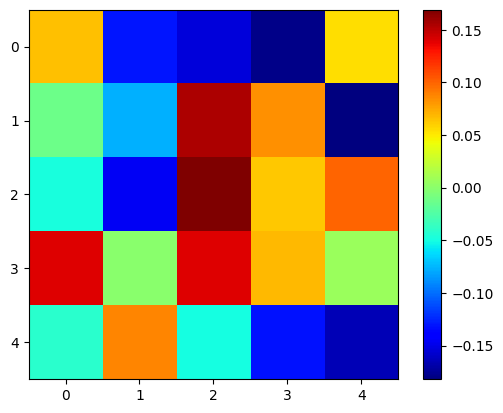

In [19]:
import matplotlib.pyplot as plt
plt.imshow(weight[0, 0, :, :], cmap='jet')
plt.colorbar()
plt.show()

In [20]:
# MNIST 데이터셋을 이용 
print(images.shape)
print(images[0].shape)
print(images[0].size())

input_image = torch.squeeze(images[0])
print(input_image.size())

torch.Size([8, 1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([28, 28])


In [21]:
input_data = torch.unsqueeze(images[0], dim=0)
print(input_data.size())

output_data = layer(input_data)
output = output_data.data
output_arr = output.numpy()
print(output_arr.shape)

torch.Size([1, 1, 28, 28])
(1, 20, 24, 24)


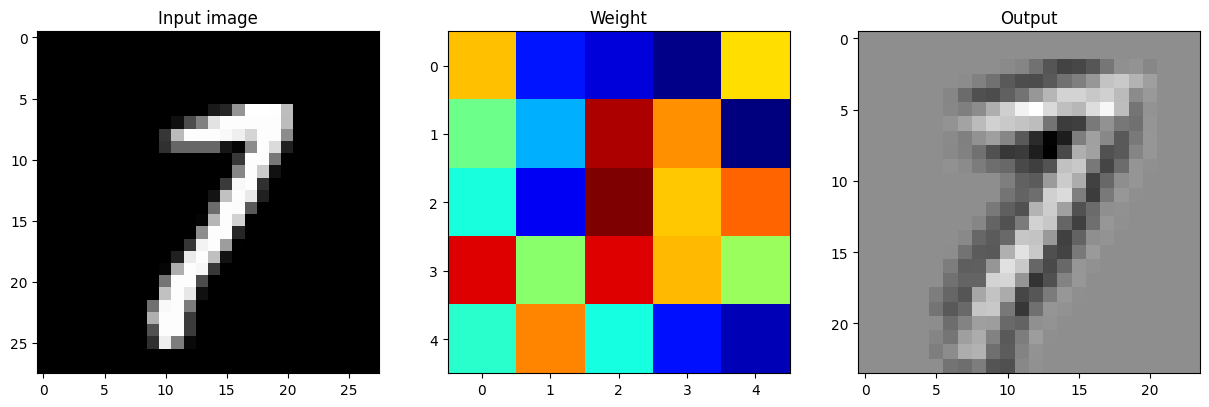

In [22]:
plt.figure(figsize=(15, 30))

plt.subplot(131)
plt.title('Input image')
plt.imshow(input_image, cmap='gray')

plt.subplot(132)
plt.title('Weight')
plt.imshow(weight[0, 0, :, :], cmap='jet')

plt.subplot(133)
plt.title('Output')
plt.imshow(output_arr[0, 0, :, :], cmap='gray')
plt.show()

### 풀링 레이어(Pooling layers)

- `F.max_pool2d`
  - `stride`
  - `kernel_size`
- `torch.nn.MaxPool2d` 도 많이 사용

In [23]:
import torch.nn.functional as F

pool = F.max_pool2d(output, 2, 2)   # 2x2 크기의 최대 풀링
pool.shape

torch.Size([1, 20, 12, 12])

- MaxPool Layer는 weight가 없기 때문에 바로 `numpy()`변환 가능

In [24]:
pool_arr = pool.numpy()
pool_arr.shape              # 크기가 절반으로 줄어듦

(1, 20, 12, 12)

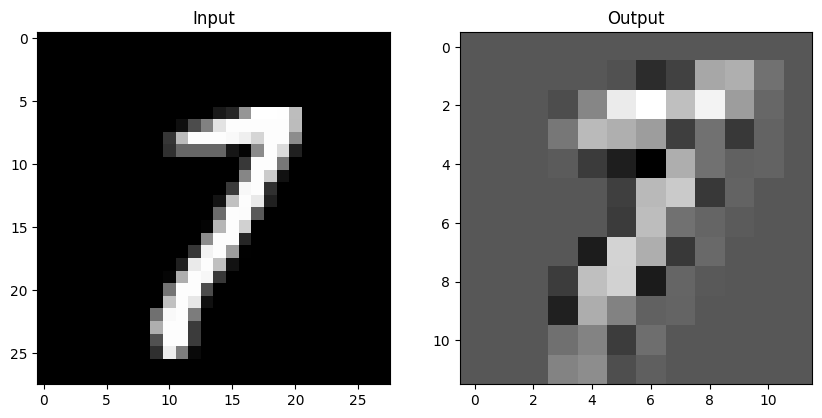

In [26]:
plt.figure(figsize=(10, 15))

plt.subplot(121)
plt.title('Input')
plt.imshow(input_image, cmap='gray')

plt.subplot(122)
plt.title('Output')
plt.imshow(pool_arr[0, 0, :, :], cmap='gray')
plt.show()

### 선형 레이어(Linear layers)

1d만 가능하므로 `.view()`를 통해 1d로 펼쳐줘야함

In [27]:
flatten = input_image.view(1, 28*28)
flatten.shape

torch.Size([1, 784])

In [28]:
lin = nn.Linear(28*28, 10)(flatten)
lin.shape

torch.Size([1, 10])

In [29]:
lin

tensor([[ 0.2158, -0.2229, -0.0276, -0.4658, -0.0943,  0.0423, -0.0770,  0.1826,
          0.0363,  0.0731]], grad_fn=<AddmmBackward0>)

In [30]:
plt.imshow(lin.detach().numpy(), cmap='jet')
plt.colorbar()
plt.show()

### 비선형 활성화 (Non-linear Activations)

`F.softmax`와 같은 활성화 함수 등

In [31]:
with torch.no_grad():
    flatten = input_image.view(1, 28*28)
    lin = nn.Linear(28*28, 10)(flatten)
    softmax = F.softmax(lin, dim=1)

softmax

tensor([[0.0826, 0.1481, 0.0777, 0.0852, 0.0905, 0.1297, 0.1052, 0.1082, 0.0810,
         0.0919]])

In [33]:
import numpy as np
np.sum(softmax.numpy())   # 1에 가까운지 확인

1.0000001

`F.relu`

- ReLU 함수를 적용하는 레이어
- `nn.ReLU`로도 사용 가능

In [35]:
inputs = torch.randn(4, 3, 28, 28).to(device='cuda' if torch.cuda.is_available() else 'cpu') # 4개의 이미지를 랜덤하게 생성
inputs.shape

torch.Size([4, 3, 28, 28])

In [36]:
layer = nn.Conv2d(3, 20, 5, 1).to(device='cuda' if torch.cuda.is_available() else 'cpu')
output = F.relu(layer(inputs))  # ReLU 활성화 함수를 적용
output.shape

torch.Size([4, 20, 24, 24])

## 모델 정의

### `nn.Module` 상속 클래스 정의
- `nn.Module`을 상속받는 클래스 정의
- `__init__()`: 모델에서 사용될 모듈과 활성화 함수 등을 정의
- `forward()`: 모델에서 실행되어야 하는 연산을 정의

In [38]:
class Model(nn.Module):                         # nn.Module을 상속받는 파이썬 클래스
    def __init__(self, inputs):
        super(Model, self).__init__()
        self.layer = nn.Linear(inputs, 1)
        self.activation = nn.Sigmoid()

    def forward(self, x):                       # 순전파 메서드
        x = self.layer(x)
        x = self.activation(x)
        return x

In [39]:
model = Model(1)                               # 모델 객체 생성
print(list(model.children()))                  # 모델의 하위 모듈 확인
print(list(model.modules()))                   # 모델의 모듈 확인

[Linear(in_features=1, out_features=1, bias=True), Sigmoid()]
[Model(
  (layer): Linear(in_features=1, out_features=1, bias=True)
  (activation): Sigmoid()
), Linear(in_features=1, out_features=1, bias=True), Sigmoid()]


### `nn.Sequential`을 이용한 신경망 정의
- `nn.Sequential` 객체로 그 안에 각 모듈을 순차적으로 실행
- `__init__()`에서 사용할 네트워크 모델들을 `nn.Sequential`로 정의 가능
- `forward()`에서 실행되어야 할 계산을 가독성 높게 작성 가능

In [40]:
class Model(nn.Module):
    def __init__(self, inputs):
        super(Model, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=30, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )

        self.layer3 = nn.Sequential(
            nn.Linear(in_features=30*5*5, out_features=10, bias=True),
            nn.ReLU(inplace=True)            
        )
        

        def forward(self, x):
            x = self.layer1(x)
            x = self.layer2(x)
            x = x.view(x.shape[0], -1)
            x = self.layer3(x)
            return x

In [42]:
model = Model(1)
print(list(model.children()))
print(list(model.modules()))

[Sequential(
  (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
), Sequential(
  (0): Conv2d(64, 30, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
), Sequential(
  (0): Linear(in_features=750, out_features=10, bias=True)
  (1): ReLU(inplace=True)
)]
[Model(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 30, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Linear(in_features=750, out_features=10, bias=True)
    (1): ReLU(inplace=True)
  )
), Sequential(
  (

### 파이토치 사전학습 모델

* https://pytorch.org/vision/stable/models.html

## 모델 파라미터

### 손실 함수(Loss function)

* 예측 값과 실제 값 사이의 오차 측정
* 학습이 진행되면서 해당 과정이 얼마나 잘 되고 있는지 나타내는 지표
* 모델이 훈련되는 동안 최소화될 값으로 주어진 문제에 대한 성공 지표
* 손실 함수에 따른 결과를 통해 학습 파라미터를 조정
* 최적화 이론에서 최소화 하고자 하는 함수
* 미분 가능한 함수 사용
* 파이토치의 주요 손실 함수
  - `torch.nn.BCELoss`: 이진 분류를 위해 사용
  - `torch.nn.CrossEntropyLoss`: 다중 클래스 분류를 위해 사용
  - `torch.nn.MSELoss`: 회귀 모델에서 사용